In [1]:
using Random
using Dates
using Optimization
using Lux
using DiffEqFlux: NeuralODE, ADAMW, swish
using DifferentialEquations
using ComponentArrays
using BSON: @save, @load

In [2]:
using DataFrames, CSV, Dates, Statistics, Plots
path = "C:\\Users\\praty\\Downloads\\seoul_ex.csv"
df = CSV.read(path, DataFrame, types = Dict(:date => Date,
                                            :temp => Float64, 
                                            :humidity => Float64,
                                            :windspeed => Float64,
                                            :sealevelpressure => Float64,
                                            :moonphase => Float64))
#temp	humidity	windspeed	sealevelpressure	moonphase
features = [:temp	,:humidity,	:windspeed,	:sealevelpressure,	:moonphase]
units = ["°F"	,"humidity%",	"km/h",	"hPa"	,"moonphase"]
feature_names = ["temp",	"humidity",	"windspeed",	"sealevelpressure",	"moonphase"]
missing_per_column = map(col -> count(ismissing, col), eachcol(df))
println("Missing values per column: $missing_per_column")
dropmissing!(df) 
missing_per_column = map(col -> count(ismissing, col), eachcol(df))
println("Missing values per column: $missing_per_column")
function normalize(x)
    μ = mean(x; dims=2)
    σ = std(x; dims=2)
    z = (x .- μ) ./ σ
    return z, μ, σ
end
function plot_features(df)
    plots = map(enumerate(zip(features, feature_names, units))) do (i, (f, n, u))
        plot(df[:, :date], df[:, f],
             title=n, label=nothing,
             ylabel=u, size=(800, 600),
             color=i)
    end

    n = length(plots)
    plot(plots..., layout=(2,3))


end
function preprocess(raw_df, num_train=35)
    raw_df[:,:year] = Float64.(year.(raw_df[:,:date]))
    raw_df[:,:month] = Float64.(month.(raw_df[:,:date]))
    df = combine(
        groupby(raw_df, [:year, :month]),
        :date => (d -> mean(year.(d)) .+ mean(month.(d)) ./ 12),
        :temp => mean,
        :humidity => mean,
	    :windspeed => mean,
	    :sealevelpressure => mean,
	    :moonphase => mean,

        renamecols=false
    )

    t_and_y(df) = df[!, :date]', Matrix(df[!, features])'
    t_train, y_train = t_and_y(df[1:num_train,:])
    t_test, y_test = t_and_y(df[num_train+1:end,:])    
    t_train, t_mean, t_scale = normalize(t_train)
    y_train, y_mean, y_scale = normalize(y_train)
    t_test = (t_test .- t_mean) ./ t_scale
    y_test = (y_test .- y_mean) ./ y_scale

    return (
        vec(t_train), y_train,
        vec(t_test),  y_test,
        (t_mean, t_scale),
        (y_mean, y_scale)
    )
end

Missing values per column: [0, 0, 0, 0, 0, 0]
Missing values per column: [0, 0, 0, 0, 0, 0]


preprocess (generic function with 2 methods)

In [3]:
mutable struct ResidualBlock
    inner_layer::Chain
end

function ResidualBlock(input_dim, hidden_dim)
    return ResidualBlock(Chain(
        Dense(input_dim, hidden_dim, swish),
        Dense(hidden_dim, input_dim)
    ))
end

ResidualBlock

In [4]:
function neural_ode(t, data_dim)
    f = Lux.Chain(
            Lux.Dense(data_dim, 32, swish),
            Lux.Dense(32, 64, swish),
            Lux.Dense(64,64,swish),
            Lux.Dense(64, 32, swish),
            Lux.Dense(32, data_dim)
        )

    node = NeuralODE(
        f, extrema(t), Tsit5(),
        saveat=t,
        abstol=1e-9, reltol=1e-9
    )
    
    rng = Random.default_rng()
    p, state = Lux.setup(rng, f)

    return node, ComponentArray(p), state
end
     

neural_ode (generic function with 1 method)

In [52]:

function train_one_round(node, θ, state, y, opt, maxiters, rng, y0=y[:, 1]; kwargs...)
    predict(θ) = Array(node(y0, θ, state)[1])
    loss(θ) = sum(abs2, predict(θ) .- y)
    
    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((θ, p) -> loss(θ), adtype)
    optprob = OptimizationProblem(optf, θ)
    res = solve(optprob, Optimisers.Adam(5e-3), maxiters=maxiters; kwargs...)
    res.minimizer, state
end


train_one_round (generic function with 2 methods)

In [50]:
function train(t, y, obs_grid, maxiters, lr, rng, θ=nothing, state=nothing; kwargs...)
    log_results(θs, losses) =
        (θ, loss) -> begin
        push!(θs, copy(θ))
        
        push!(losses, loss)
        false
    end

    θs, losses = ComponentArray[], Float32[]
    for k in obs_grid
        node, θ_new, state_new = neural_ode(t, size(y, 1))
        if θ === nothing θ = θ_new end
        if state === nothing state = state_new end

        θ, state = train_one_round(
            node, θ, state, y, Adam(lr), maxiters, rng;
            callback=log_results(θs, losses),
            kwargs...
        )
    end
    final_loss=0
    θs, state, losses, final_loss
 
end


train (generic function with 3 methods)

[ Info: Fitting model...


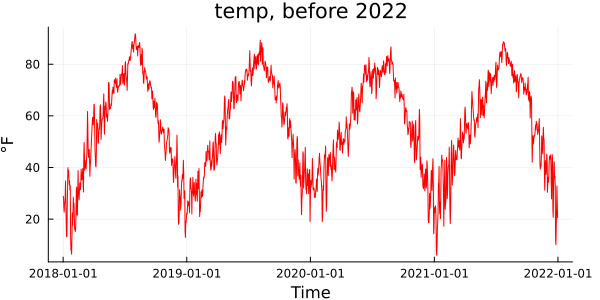

In [8]:
@info "Fitting model..."
colors = [:red, :blue, :green, :orange, :purple]
rng = MersenneTwister(123)

plt_features = plot_features(df)


df_2016 = filter(x -> x.date < Date(2022, 1, 1), df)
plt_2016 = plot(
    df_2016.date,
    df_2016.temp,
    title = "temp, before 2022",
    ylabel = units[1],
    xlabel = "Time",
    color = colors[1],
    size = (600, 300),
    label = nothing,
    right_margin=5Plots.mm
)

[ Info: Fitting model...


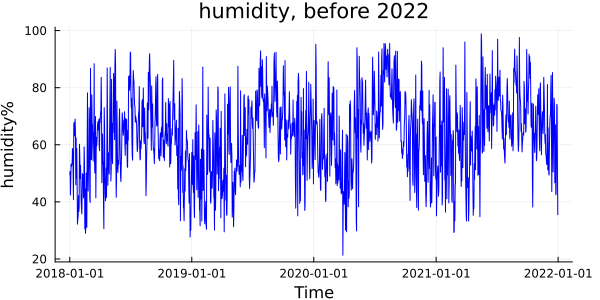

In [9]:
@info "Fitting model..."
colors = [:red, :blue, :green, :orange, :purple]
rng = MersenneTwister(123)

plt_features = plot_features(df)


df_2016 = filter(x -> x.date < Date(2022, 1, 1), df)
plt_2016 = plot(
    df_2016.date,
    df_2016.humidity,
    title = "humidity, before 2022",
    ylabel = units[2],
    xlabel = "Time",
    color = colors[2],
    size = (600, 300),
    label = nothing,
    right_margin=5Plots.mm
)

[ Info: Fitting model...


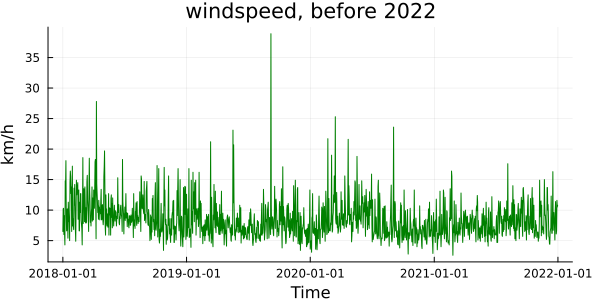

In [10]:
@info "Fitting model..."
rng = MersenneTwister(123)

plt_features = plot_features(df)


df_2016 = filter(x -> x.date < Date(2022, 1, 1), df)
plt_2016 = plot(
    df_2016.date,
    df_2016.windspeed,
    title = "windspeed, before 2022",
    ylabel = units[3],
    xlabel = "Time",
    color = colors[3],
    size = (600, 300),
    label = nothing,
    right_margin=5Plots.mm
)

[ Info: Fitting model...


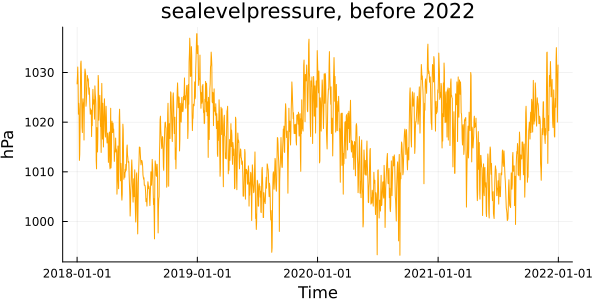

In [11]:
@info "Fitting model..."
rng = MersenneTwister(123)

plt_features = plot_features(df)


df_2016 = filter(x -> x.date < Date(2022, 1, 1), df)
plt_2016 = plot(
    df_2016.date,
    df_2016.sealevelpressure,
    title = "sealevelpressure, before 2022",
    ylabel = units[4],
    xlabel = "Time",
    color = colors[4],
    size = (600, 300),
    label = nothing,
    right_margin=5Plots.mm
)

[ Info: Fitting model...


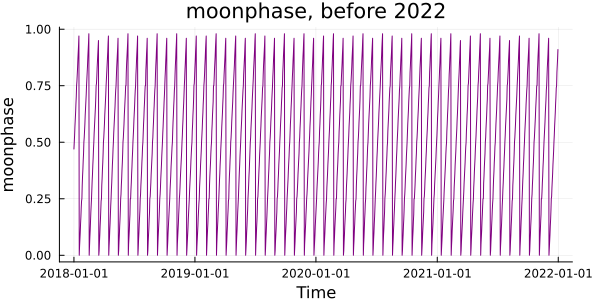

In [12]:
@info "Fitting model..."
rng = MersenneTwister(123)

plt_features = plot_features(df)


df_2016 = filter(x -> x.date < Date(2022, 1, 1), df)
plt_2016 = plot(
    df_2016.date,
    df_2016.moonphase,
    title = "moonphase, before 2022",
    ylabel = units[5],
    xlabel = "Time",
    color = colors[5],
    size = (600, 300),
    label = nothing,
    right_margin=5Plots.mm
)

In [13]:
t_train, y_train, t_test, y_test, (t_mean, t_scale), (y_mean, y_scale) = preprocess(df)

([-1.6590301240125898, -1.5614401167175593, -1.4638501094227951, -1.3662601021280307, -1.2686700948330003, -1.1710800875382361, -1.0734900802434717, -0.9759000729484413, -0.8783100656536771, -0.7807200583589128  …  0.7807200583589128, 0.8783100656536771, 0.9759000729484413, 1.0734900802434717, 1.1710800875382361, 1.2686700948330003, 1.3662601021280307, 1.4638501094227951, 1.5614401167175593, 1.6590301240125898], [-1.7615452949442554 -1.5397928831969092 … 0.05733437544420836 -0.5602554908343728; -1.2659888987013965 -1.7551351723332163 … -0.14367414876872947 0.14870478305385557; … ; 1.1631718343980468 1.0656982030882307 … 0.598683273859217 1.1942472147508805; 0.04844341841061332 0.8590589158586679 … 0.43945401110909577 -0.6100680718323969], [1.7566201313073542, 1.8542101386021184, 1.9518001458971488, 2.049390153191913, 2.1469801604866774, 2.244570167781708, 2.3421601750764722, 2.4397501823712364, 2.537340189666267, 2.6349301969610313, 2.7325202042557954, 2.830110211550826, 2.927700218845

In [14]:
t_train

35-element Vector{Float64}:
 -1.6590301240125898
 -1.5614401167175593
 -1.4638501094227951
 -1.3662601021280307
 -1.2686700948330003
 -1.1710800875382361
 -1.0734900802434717
 -0.9759000729484413
 -0.8783100656536771
 -0.7807200583589128
 -0.6831300510638822
 -0.5855400437691181
 -0.48795003647435375
  ⋮
  0.5855400437691181
  0.6831300510638822
  0.7807200583589128
  0.8783100656536771
  0.9759000729484413
  1.0734900802434717
  1.1710800875382361
  1.2686700948330003
  1.3662601021280307
  1.4638501094227951
  1.5614401167175593
  1.6590301240125898

In [15]:
using Optimisers
using OptimizationOptimisers

In [46]:
using Optimisers: Adam

In [ ]:

obs_grid = 4:4:length(t_train) # we train on an increasing amount of the first k obs
maxiters = 400
lr = 5e-3
θs, state, losses, final_loss = train(t_train, y_train, obs_grid, maxiters, lr, rng, progress=true);


predict(y0, t, θ, state) = begin
    node, _, _ = neural_ode(t, length(y0))
    ŷ = Array(node(y0, θ, state)[1])
end


loss: 131: 100%|████████████████████████████████████████| Time: 0:26:34m
loss: 79.6: 100%|███████████████████████████████████████| Time: 0:37:05
loss: 41.3: 100%|███████████████████████████████████████| Time: 1:07:33
loss: 119:  28%|████████████                            |  ETA: 1:10:15

In [18]:
@save "mymodelnew.bson" predict

LoadError: UndefVarError: predict not defined

In [19]:
colors = [:red, :blue, :green, :orange, :purple]
function plot_pred(t, y, ŷ)
    plt = Plots.scatter(t, y, label="Observation")
    Plots.plot!(plt, t, ŷ, label="Prediction")
end

function plot_pred(t, y, t̂, ŷ; kwargs...)
    plot_params = zip(eachrow(y), eachrow(ŷ), feature_names, units)
    plts_preds = map(enumerate(plot_params)) do (i, (yᵢ, ŷᵢ, name, unit))
        plt = Plots.plot(
            t̂, ŷᵢ, label="Prediction", color=colors[i], linewidth=3,
            legend=nothing, title=name; kwargs...
        )
        Plots.scatter!(
            plt, t, yᵢ, label="Observation",
            xlabel="Time", ylabel=unit,
            markersize=5, color=i
        )
    end
end

function plot_result(t, y, t̂, ŷ, loss, num_iters; kwargs...)
    plot_params = zip(eachrow(y), eachrow(ŷ), feature_names, units)
    plts_preds = plot_pred(t, y, t̂, ŷ; kwargs...)
    plot!(plts_preds[1], ylim=(0, 100), legend=(0.65, 1.0))
    plot!(plts_preds[2], ylim=(30, 100))
    plot!(plts_preds[3], ylim=(5, 20))
    plot!(plts_preds[4], ylim=(990, 1050))
    plot!(plts_preds[5], ylim=(0.4, 0.6))


    p_loss = Plots.plot(
        loss, label=nothing, linewidth=3,
        title="Loss", xlabel="Iterations",
        xlim=(0, num_iters)
    )
    plots = [plts_preds..., p_loss]
    plt = Plots.plot(plots..., layout=grid(length(plots), 1), size=(900, 900))
end

function animate_training(plot_frame, t_train, y_train, θs, losses, obs_grid; pause_for=300)
    obs_count = Dict(i - 1 => n for (i, n) in enumerate(obs_grid))
    is = [min(i, length(losses)) for i in 2:(length(losses) + pause_for)]
    @animate for i in is
        stage = Int(floor((i - 1) / length(losses) * length(obs_grid)))
        k = obs_count[stage]
        plt = plot_frame(t_train[1:k], y_train[:,1:k], θs[i], losses[1:i])
    end every 2
end

function plot_extrapolation(t_train, y_train, t_test, y_test, t̂, ŷ)
    plts = plot_pred(t_train, y_train, t̂, ŷ)
    for (i, (plt, y)) in enumerate(zip(plts, eachrow(y_test)))
        Plots.scatter!(plt, t_test, y, color=colors[i], markerstrokecolor=:white, label="Test observation")
    end

    plot!(plts[1], ylim=(0, 100), legend=:topleft)
    plot!(plts[2], ylim=(30,100))
    plot!(plts[3], ylim=(5, 20))
    plot!(plts[4], ylim=(990, 1060))
    plot!(plts[5], ylim=(0.4, 0.6))
    Plots.plot(plts..., layout=grid(length(plts), 1), size=(900, 900))
end

plot_extrapolation (generic function with 1 method)

In [20]:

function plot_pred(
    t_train, y_train, t_grid,
    rescale_t, rescale_y, num_iters, θ, state, loss, y0=y_train[:, 1]
)
    ŷ = predict(y0, t_grid, θ, state)
    plt = plot_result(
        rescale_t(t_train),
        rescale_y(y_train),
        rescale_t(t_grid),
        rescale_y(ŷ),
        loss,
        num_iters
    )
end

@info "Generating training animation..."
num_iters = length(losses)
t_train_grid = collect(range(extrema(t_train)..., length=500))
rescale_t(x) = t_scale .* x .+ t_mean
rescale_y(x) = y_scale .* x .+ y_mean
plot_frame(t, y, θ, loss) = plot_pred(
    t, y, t_train_grid, rescale_t, rescale_y, num_iters, θ, state, loss
)
anim = animate_training(plot_frame, t_train, y_train, θs, losses, obs_grid);


@info "Generating extrapolation plot..."
t_grid = collect(range(minimum(t_train), maximum(t_test), length=500))
ŷ = predict(y_train[:,1], t_grid, θs[end], state)
plt_ext = plot_extrapolation(
    rescale_t(t_train),
    rescale_y(y_train),
    rescale_t(t_test),
    rescale_y(y_test),
    rescale_t(t_grid),
    rescale_y(ŷ)
);


@info "Done!"

[ Info: Generating training animation...


LoadError: UndefVarError: losses not defined

In [21]:
display(plt_ext)

LoadError: UndefVarError: plt_ext not defined

In [22]:
gif(anim, fps=10)

LoadError: UndefVarError: anim not defined